In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
import json
from pandas.io.json import json_normalize
from IPython.display import display
from pandas import HDFStore,DataFrame
import pandas as pd
import pickle

%matplotlib inline 

<h2>Open files and read in dataframes</h2>

In [33]:
filename = '../Federica/DataPopularity_ML/simpleModel_start_2017-02-17_meas_7_pred_7'

df_X = pd.read_hdf(filename+'.h5', 'X')
df_Y = pd.read_hdf(filename+'.h5', 'Y')
df_Y.sum()

273

In [3]:
#Facultative! try to improve modelling by dropping a few columns (dsid, ptag)

display(df_X.shape)
#df_X = df_X.drop([col for col in df_X.columns if 'dsid' in col], axis=1)
#df_X = df_X.drop([col for col in df_X.columns if 'ptag' in col], axis=1)
#df_X =  df_X.drop([col for col in df_X.columns if 'type' in col], axis=1)
#df_X =  df_X.drop([col for col in df_X.columns if 'scope' in col], axis=1)
display(df_Y.shape)

(30321, 14)

(30321,)

In [4]:
#check what they look like

display(df_X.head(5))
display(df_Y.head(5))

print('Total df')
display(df_X.shape)
display(df_Y.shape)

display(df_X[df_Y<0.5].shape)
display(df_X[df_Y>0.5].shape)   

,name,scope,user,taskid,cputime,pandaid,size,nfiles,site,walltime,nevents,dsid,ptag,type
0,data15_13TeV.00266904.physics_Main.merge.DAOD_...,data15_13TeV,2,2,521,22,140932680,364,4,6201,772,266904,2950,DAOD_EGAM1
1,data15_13TeV.00266904.physics_Main.merge.DAOD_...,data15_13TeV,4,5,4125,226,157285182,226,7,45990,5822,266904,2950,DAOD_EXOT17
2,data15_13TeV.00266904.physics_Main.merge.DAOD_...,data15_13TeV,1,1,424,15,446525578,71,1,3188,0,266904,2880,DAOD_HIGG2D1
3,data15_13TeV.00266904.physics_Main.merge.DAOD_...,data15_13TeV,1,1,475,11,593515038,74,1,8940,20192,266904,2950,DAOD_HIGG4D3
4,data15_13TeV.00266904.physics_Main.merge.DAOD_...,data15_13TeV,2,2,265,11,63051094,113,2,2992,2720,266904,2950,DAOD_HIGG4D5


0    0
1    0
2    0
3    0
4    0
Name: accessed, dtype: int64

Total df


(30321, 14)

(30321,)

(30048, 14)

(273, 14)

<h2>Transform to np.array</h2>

In [37]:
#drop strings...
df_X = df_X.drop([col for col in df_X.columns if 'dsid' in col], axis=1)
df_X = df_X.drop([col for col in df_X.columns if 'ptag' in col], axis=1)
df_X =  df_X.drop([col for col in df_X.columns if 'type' in col], axis=1)
df_X =  df_X.drop([col for col in df_X.columns if 'scope' in col], axis=1)
df_X =  df_X.drop([col for col in df_X.columns if 'name' in col], axis=1)

X = df_X.as_matrix().astype(np.float)
Y = df_Y.as_matrix().astype(np.float)

## The Training and Testing Split

This will split data into train-test sets: 67%-33%. It will also shuffle entries so you will not get the first 67% of `X` for training and the last 33% for testing. The first will be used for training the classifier and the second to evaluate its performance.

In [213]:
from sklearn.model_selection import train_test_split

#first split into development (to optimise hyperparameters) and evaluation (to train+test final model) samples
#X_dev,X_eval, y_dev,y_eval = train_test_split(X, Y, test_size=0.50, random_state=42)
#X = X_eval
#Y = y_eval

#print('Used for development (hyperparameters optimization): '+str(len(y_dev)))
#print('Used for training+testing: '+str(len(y_eval)))

X_train, X_test, y_train,y_test = train_test_split(X, Y, test_size=0.33, random_state=492)

print('Used for training: '+str(len(y_train)))
print('Used for testing:  '+str(len(y_test)))

Used for training: 20315
Used for testing:  10006


## Assessing a Classifier's Performance

All the fucntions below will be used once the model is trained

Documentation:
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

In [2]:
def checkPrediction(X, Y, bdt):
    from sklearn.metrics import mean_squared_error
    
    y_predicted = bdt.predict(X)
    print(classification_report(Y, y_predicted, target_names=["background", "signal"]))
    print("Area under ROC curve: %.4f"%(roc_auc_score(Y, bdt.decision_function(X)))) 
    print("MSE (Mean Square Error): %.4f" % (mean_squared_error(Y, y_predicted)))
    return

In [3]:
#confusion matrix

def cmReport(CM):
  
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]


    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN) # signal corrected identified/ (true signal+signal misidentified as background==total true signal)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) # background correctly identified / (true background+background misidentified as signal==total true background)    
    # Precision or positive predictive value
    PPV = TP/(TP+FP) # signal corrected identified/ (true signal+background as signal ==total recognized signal)   
    # Negative predictive value
    NPV = TN/(TN+FN) # background corrected identified/ (true background+ signal as background ==total recognized background)
    # Fall out or false positive rate
    FPR = FP/(FP+TN) # misidentified background/total background

    # False negative rate
    FNR = FN/(TP+FN) # misidentified signal/total signal
    # False discovery rate
    FDR = FP/(TP+FP) # misidentified background/total recognized signal
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    print('TP ' + str(TP) + ' FP '+ str(FP) +' TN ' + str(TN) + ' FN ' + str(FN))
    print('Sensitivity, hit rate, recall, or true positive rate '+str(round(TPR, 3)))
    print('Specificity or true negative rate '+str(round(TNR, 3)))
    print('Precision or positive predictive value '+str(round(PPV, 3)))
    print('Negative predictive value '+str(round(NPV, 3)))
    print('Fall out or false positive rate '+str(round(FPR, 3)))    
    print('False negative rate '+str(round(FNR, 3)))    
    print('False discovery rate '+str(round(FDR, 3)))
    print('overall accuracy '+str(round(ACC, 3)))
    
    return

In [4]:
def plotROC(bdt, X):
    
    from sklearn.metrics import roc_curve, auc

    decisions = bdt.decision_function(X_test)
    
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y_test, decisions)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate (Background rejection)')
    plt.ylabel('True Positive Rate (Signal efficiency)')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    
    return

In [5]:
#Overtraining

def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')


In [6]:
#To test prediction in future

#open files and check dataframes have same structure (i.e. number of columns)

def getMLInputs(filename, df_X_ref):

    df_X = pd.read_hdf(filename, 'X')
    df_Y = pd.read_hdf(filename, 'Y')

    #Match columns of df_X with reference df_X_ref     
    idx_ref = df_X_ref.columns
    idx = df_X.columns

    #print('Before')
    #display(df_X.shape)
    #display(df_X_ref.shape)

    #Return a new Index with elements from the idx that are not in idx_ref. -> They need to be removed
    new = idx.difference(idx_ref)
    df_X = df_X.drop(new, axis=1)

    #print('Drop new columns')
    #display(df_X.shape)

    #add missing columns in new dataframe, they need to be added with 0
    df_X = df_X.reindex(columns=idx_ref, fill_value=0)

    #print('Add old columns and fill with 0')
    #display(df_X.shape)
    
    #convert to np array
    X = df_X.as_matrix().astype(np.float)
    Y = df_Y.as_matrix().astype(np.float)

    return X, Y

## Methods: Decision Trees

Training a [AdaBoost Decision Tree](//en.wikipedia.org/wiki/AdaBoost). 
After instantiating our [`AdaBoostClassifier`](//scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), call the `fit()` method with the training sample as an argument. The `fit()` method trains the tree and returns the trained classifier. When printed out all the hyper-parameters are listed.

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=8)

bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=10, #was 800
                         learning_rate=0.5)

bdt.fit(X_train, y_train)

#save model
pickle.dump(bdt, open(filename+'_bdt.sav', 'wb'))

KeyboardInterrupt: 

## Methods: Stochastic gradient descent (SGD)

stochastic gradient descent (SGD)
Observation: with default parameters, not good performances (~10% error on first week)

In [219]:
from sklearn import linear_model

bdt = linear_model.SGDClassifier()
bdt.fit(X_train, y_train)

#save model
pickle.dump(bdt, open(filename+'_sgd.sav', 'wb'))

In [164]:
bdt = pickle.load(open(filename+'_bdt.sav', 'rb'))

## Check performances

Using functions bdefined above

In [225]:
checkPrediction(X_test, y_test, bdt)

             precision    recall  f1-score   support

 background       0.99      0.99      0.99      9934
     signal       0.23      0.24      0.23        72

avg / total       0.99      0.99      0.99     10006

Area under ROC curve: 0.9321
MSE (Mean Square Error): 0.0112


The same performance metrics evaluated on the training set instead. You can see the estimates of the performance are more optimistic than on an unseen set of events.

In [14]:
checkPrediction(X_train, y_train, bdt)

             precision    recall  f1-score   support

 background       1.00      1.00      1.00     20114
     signal       1.00      0.99      0.99       201

avg / total       1.00      1.00      1.00     20315

Area under ROC curve: 1.0000
MSE (Mean Square Error): 0.0001


In [226]:
#Look at confusion matrix
#TN|FP - background OK - background as signal
#FN|TP - signal as background - signal OK
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y_test, bdt.predict(X_test))
#display(CM)
cmReport(CM)

TP 17 FP 57 TN 9877 FN 55
Sensitivity, hit rate, recall, or true positive rate 0.24
Specificity or true negative rate 0.99
Precision or positive predictive value 0.23
Negative predictive value 0.99
Fall out or false positive rate 0.01
False negative rate 0.76
False discovery rate 0.77
overall accuracy 0.99


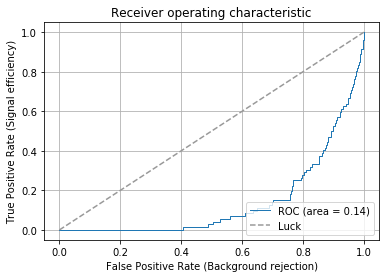

In [222]:
#look at ROC curve
plotROC(bdt, X_test)

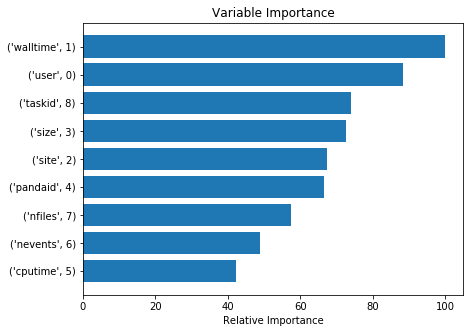

In [227]:
nmax = 10 # maximum number of features
feature_importance = bdt.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx_first = sorted_idx[-nmax:]
#display(sorted_idx_first)
pos = np.arange(sorted_idx_first.shape[0]) + .5

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 2)

features = list(df_X)
y_ticks = sorted(zip(features, sorted_idx))
#display(features)

plt.barh(pos, feature_importance[sorted_idx_first], align='center')
plt.yticks(pos, y_ticks[-nmax:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Overtraining Check

Comparing the BDT's output distribution for the training and testing set.

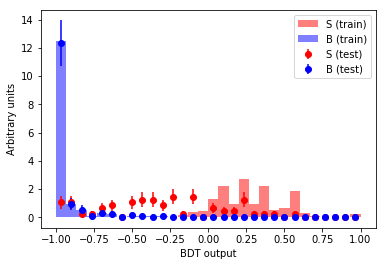

In [228]:
compare_train_test(bdt, X_train, y_train, X_test, y_test)

## Testing prediction power in the future

How well does it work in 1, 2, or n weeks?

## Simple model

In [19]:
#weekly measurement
start = datetime.date(2017, 2, 17)         # measurement: starting date
time_meas = 7                              # popularity measurement: # of days
time_pred = 7                              # popularity prediction: # of days    

#CMS
#start = datetime.date(2016, 5, 15)         # measurement: starting date
#time_meas = 26*7                           # popularity measurement: # of days
#time_pred = 7                              # popularity prediction: # of days 

#make dataframes for 7 weeks
for x in range(0, 4):

    st = start+x*datetime.timedelta(days=7)
    print('\n Prediction starting from '+str(st))    
    filename = '../Federica/DataPopularity_ML/simpleModel_start_'+str(st)+'_meas_'+str(time_meas)+'_pred_'+str(time_pred)+'.h5'
    X_future, Y_future = getMLInputs(filename, df_X)
    checkPrediction(X_future, Y_future, bdt)


 Prediction starting from 2017-02-17
             precision    recall  f1-score   support

 background       1.00      1.00      1.00     30048
     signal       0.81      0.78      0.80       273

avg / total       1.00      1.00      1.00     30321

Area under ROC curve: 0.9785
MSE (Mean Square Error): 0.0036

 Prediction starting from 2017-02-24
             precision    recall  f1-score   support

 background       1.00      0.99      0.99     31086
     signal       0.17      0.23      0.19       180

avg / total       0.99      0.99      0.99     31266

Area under ROC curve: 0.9398
MSE (Mean Square Error): 0.0111

 Prediction starting from 2017-03-03
             precision    recall  f1-score   support

 background       0.99      0.99      0.99     26514
     signal       0.07      0.08      0.08       183

avg / total       0.99      0.99      0.99     26697

Area under ROC curve: 0.8728
MSE (Mean Square Error): 0.0128

 Prediction starting from 2017-03-10
             precisi

## Cross-validation

In the process of choosing your classifier and setting its hyper-parameters you
normally use a training and testing set of events. However if you want to optimise
your hyper-parameters you run the risk of over-fitting your test set by changing
the hyper-parameters until you find the set which performs best on the testing set.

Cross-validation (CV) offers a way out! In its most basic form it is called
_k-fold_ CV. You split your development set into $k$ samples. Then use $k-1$ 
of the sub-samples for training and the other sample for testing. For example
if you split your development set into three parts (0, 1, 2) you would get
three estimates of the classifier's performance:

* train on 0, 1 and evaluate on 2
* train on 1, 2 and evaluate on 0
* train on 0, 2 and evaluate on 1

Then average the performance measure from each of the iterations, this is what
you end up reporting. It also allows you to compute the standard deviation of
your performance metric, so you get an uncertainty as well.

The scikit-learn documentation has a nice guide on [Cross-validation: evaluating estimator performance](//scikit-learn.org/stable/modules/cross_validation.html).

The simplest way to use CV in `scikit-learn` is the `cross_val_score`
function:

In [20]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(bdt,
                         X_dev, y_dev,
                         scoring = "roc_auc",
                         n_jobs = 6,
                         cv = 3)

NameError: name 'X_dev' is not defined

In [30]:
print("Accuracy: %0.5f (+/- %0.5f)"%(scores.mean(), scores.std()))

Accuracy: 0.84387 (+/- 0.02363)


## Optimising Hyper-parameters

Each machine learning technique has a set of parameters which are not learnt from the training data. For example the number of trees in your ensemble of decision trees, or how deep each tree should be. These are called hyper-parameters. The best value for each of them depends on the particular learning problem you are trying to solve. Therefore it makes sense to try and find the best set of hyper-parameters

Once you are familiar with CV you will want to use it to find the best set of hyper-parameters for your learning problem. The easiest way to do that is to perform a [grid search](//scikit-learn.org/stable/modules/grid_search.html) over the parameter space. In `scikit-learn` this functionality is provided by `GridSearchCV`:

In [31]:
from sklearn.model_selection import GridSearchCV

# Perform grid search over all combinations of these hyper-parameters
param_grid = {#"n_estimators": [50,200,400,1000], #takes forever
              'base_estimator__max_depth':[1,3,5], #"max_depth": [1, 3, 8],
              'learning_rate': [0.1, 0.5, 1.]}

clf = GridSearchCV(bdt,
                param_grid,
                cv=3,
                scoring='roc_auc',
                n_jobs=8)

_ = clf.fit(X_dev, y_dev)

In [32]:
# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [33]:
report(clf.cv_results_)

Model with rank: 1
Mean validation score: 0.933 (std: 0.015)
Parameters: {'learning_rate': 0.5, 'base_estimator__max_depth': 5}

Model with rank: 2
Mean validation score: 0.932 (std: 0.018)
Parameters: {'learning_rate': 0.5, 'base_estimator__max_depth': 3}

Model with rank: 3
Mean validation score: 0.931 (std: 0.030)
Parameters: {'learning_rate': 1.0, 'base_estimator__max_depth': 3}

Model with rank: 4
Mean validation score: 0.920 (std: 0.007)
Parameters: {'learning_rate': 1.0, 'base_estimator__max_depth': 5}

Model with rank: 5
Mean validation score: 0.918 (std: 0.015)
Parameters: {'learning_rate': 1.0, 'base_estimator__max_depth': 1}



For a large number of hyper-parameter combinations it will take a long time to evaluate them all. [`RandomizedSearchCV`](//scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization) samples from distributions of the hyper-parameters and evaluates random points. This can be quicker.

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# Perform random search over all combinations of these hyper-parameters
param_grid = {"n_estimators": sp_randint(1, 11),
              'base_estimator__max_depth':sp_randint(1, 11), 
              #'learning_rate': sp_randint(0.2, 1)
             }

# run randomized search
n_iter_search = 20

rnd = RandomizedSearchCV(bdt, param_grid, n_iter=n_iter_search)
_ = rnd.fit(X_dev, y_dev)

In [35]:
report(rnd.cv_results_)

Model with rank: 1
Mean validation score: 0.991 (std: 0.000)
Parameters: {'n_estimators': 4, 'base_estimator__max_depth': 1}

Model with rank: 2
Mean validation score: 0.990 (std: 0.000)
Parameters: {'n_estimators': 2, 'base_estimator__max_depth': 3}

Model with rank: 3
Mean validation score: 0.990 (std: 0.000)
Parameters: {'n_estimators': 1, 'base_estimator__max_depth': 2}

Model with rank: 3
Mean validation score: 0.990 (std: 0.000)
Parameters: {'n_estimators': 1, 'base_estimator__max_depth': 2}

Model with rank: 5
Mean validation score: 0.990 (std: 0.001)
Parameters: {'n_estimators': 4, 'base_estimator__max_depth': 2}



## Validation curves

Another useful tool for picking your final model are validation curves. It can help you answer the question: should my model be more complex?

A larger number of boosting iterations usually means a more complex classifier. We can evaluate the performance of our classifier after each boosting iteration and compare the training and testing score.

In order to visualise the small changes in the score as we get to higher boosting iterations we plot 1-score. This means that smaller is better.

To illustrate how differently the same type of classifier can behave for different hyper-parameters we will train four different ones varying the `max_depth` and `learning_rate` parameter.

In [36]:
# Split development set into a train and test sample
X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev, test_size=0.33, random_state=4685)

bdts = []
params = ((1.,4), (1.,8),
          (0.2,4), (0.2,8))

for learn,depth in params:
    dt = DecisionTreeClassifier(max_depth=depth)
    gbt_bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=6, #was 800
                         learning_rate=learn)

    gbt_bdt.fit(X_train, y_train)
    bdts.append(gbt_bdt)

The `validation_curve` function will plot the area under the ROC after each boosting iteration for each of the classifiers. The solid line shows the performance on the testing sample and the dashed line shows the performance on the training sample.

In almost all cases the performance on the training sample keeps improving as we increase the number of boosting iterations.

In [37]:
def validation_curve(bdts, train, test):
    X_test, y_test = test
    X_train, y_train = train
    
    for n,clf in enumerate(bdts):
        test_score = np.empty(len(clf.estimators_))
        train_score = np.empty(len(clf.estimators_))

        for i, pred in enumerate(clf.staged_decision_function(X_test)):
            test_score[i] = 1-roc_auc_score(y_test, pred)

        for i, pred in enumerate(clf.staged_decision_function(X_train)):
            train_score[i] = 1-roc_auc_score(y_train, pred)

        best_iter = np.argmin(test_score)
        learn = clf.get_params()['learning_rate']
        depth = clf.get_params()['base_estimator__max_depth']
        test_line = plt.plot(test_score,
                             label='learn=%.1f depth=%i (%.2f)'%(learn,depth,
                                                                 test_score[best_iter]))

        colour = test_line[-1].get_color()
        plt.plot(train_score, '--', color=colour)
        
        plt.xlabel("Number of boosting iterations")
        plt.ylabel("1 - area under ROC")
        plt.axvline(x=best_iter, color=colour)
        
    plt.legend(loc='best')

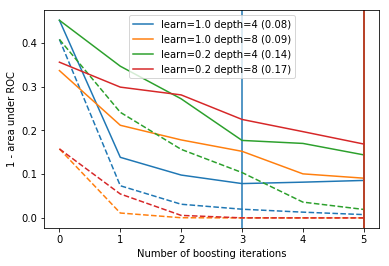

In [38]:
validation_curve(bdts,
                 (X_train,y_train),
                 (X_test,y_test))

## Learning curves

To answer the question of whether more training events would improve the performance we can evaluate the performance of a classifier when trained on a increasingly larger fraction of the test set. Broadly speaking, if the train and test score have plateaued/converged there is not much to be gained by adding more training examples. If the training error stays somewhat constant with training size and there is a large gap to the testing score, then there might be gains to be made by increasing the number of training events.

In [39]:
from sklearn.model_selection import learning_curve

# Taken more or less straight from
# http://scikit-learn.org/stable/auto_examples/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),
                        scoring=None, ax=None, xlabel=True):
    if ax is None:
        plt.figure()
        ax.title(title)
    
    if xlabel:
        ax.set_xlabel("Training examples")
        
    ax.set_ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                            X, y,
                                                            cv=cv,
                                                            n_jobs=n_jobs,
                                                            train_sizes=train_sizes,
                                                            scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    ax.set_ylim([0.65, 1.0])
    return plt


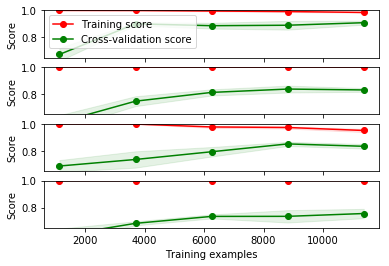

In [40]:
classifiers = [bdts[0], bdts[1], bdts[2], bdts[3]]

plt.figure(figsize=(40,40))
fig, axes = plt.subplots(nrows=len(classifiers), sharex=True)

for clf, ax in zip(classifiers, axes):  
    plot_learning_curve(clf,
                        "Learning curves",
                        X_dev, y_dev,
                        scoring='roc_auc',
                        n_jobs=7, cv=4,
                        ax=ax, xlabel=False)
    
axes[0].legend(loc="best")
axes[-1].set_xlabel("Training examples")

In [7]:
df_1sem2016 = pd.read_hdf('../Matteo/store_access>0.h5', key = 'df_1sem2016')

In [8]:
df_2sem2016 = pd.read_hdf('../Matteo/store_access>0.h5', key = 'df_2sem2016')

In [9]:
df_1sem2017 = pd.read_hdf('../Matteo/store_access>0.h5', key = 'df_1sem2017')

In [10]:
df_year2016 = pd.read_hdf('../Matteo/store_access>0.h5', key = 'df_year2016')

In [11]:
df_total = pd.read_hdf('../Matteo/store_access>0.h5', key = 'df_total')

In [12]:
df_1trim2016 = pd.read_hdf('../Matteo/store_access>0.h5', key='df_1trim2016')

In [13]:
df_2trim2016 = pd.read_hdf('../Matteo/store_access>0.h5', key='df_2trim2016')

In [14]:
df_3trim2016 = pd.read_hdf('../Matteo/store_access>0.h5', key='df_3trim2016')

In [15]:
df_4trim2016 = pd.read_hdf('../Matteo/store_access>0.h5', key='df_4trim2016')

In [16]:
df_1trim2017 = pd.read_hdf('../Matteo/store_access>0.h5', key='df_1trim2017')

In [17]:
df_2trim2017 = pd.read_hdf('../Matteo/store_access>0.h5', key='df_2trim2017')

In [9]:
df_1sem2016[df_1sem2016['nevents'] > 6900000].count()

name        12189
scope       12189
dsid        12189
ptag        12189
type        12189
cputime     12189
size        12189
taskid      12189
user        12189
walltime    12189
site        12189
pandaid     12189
nevents     12189
nfiles      12189
dtype: int64

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
cv_scope = cv.fit_transform(list(df_1sem2016.scope))
cv_scope_array = cv_scope.toarray()
print(cv_scope_array)
print(type(cv_scope_array))

[[1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]]
<class 'numpy.ndarray'>


In [11]:
cv_scope_array.shape

(122427, 10)

In [12]:
tv = CountVectorizer()
tv_type=tv.fit_transform(list(df_1sem2016.type))
tv_type_array = tv_type.toarray()
print(tv_type_array)
print(type(tv_type_array))

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
<class 'numpy.ndarray'>


In [13]:
tv_type_array.shape

(122427, 102)

In [14]:
df_X =  df_1sem2016.drop([col for col in df_1sem2016.columns if 'type' in col], axis=1)
df_X =  df_X.drop([col for col in df_X.columns if 'scope' in col], axis=1)
df_X =  df_X.drop([col for col in df_X.columns if 'name' in col], axis=1)

In [15]:
df_X.head(5)

,dsid,ptag,cputime,size,taskid,user,walltime,site,pandaid,nevents,nfiles
0,178044,811,32586,209093135328,8,8,60435,8,51,1771256,56
1,178047,811,1401,5942572424,8,8,3720,8,8,45912,8
2,178109,811,91322,373981640121,10,10,182843,10,84,3320622,99
3,179710,811,52033,337254720728,9,9,88649,9,80,2599976,88
4,179725,811,21981,137957583000,8,8,35439,9,32,1015208,40


In [16]:
df_X =  df_X.drop([col for col in df_X.columns if 'size' in col], axis=1)
df_X =  df_X.drop([col for col in df_X.columns if 'pandaid' in col], axis=1)
df_X =  df_X.drop([col for col in df_X.columns if 'nfiles' in col], axis=1)
df_X =  df_X.drop([col for col in df_X.columns if 'nevents' in col], axis=1)

In [17]:
df_X.head(5)

,dsid,ptag,cputime,taskid,user,walltime,site
0,178044,811,32586,8,8,60435,8
1,178047,811,1401,8,8,3720,8
2,178109,811,91322,10,10,182843,10
3,179710,811,52033,9,9,88649,9
4,179725,811,21981,8,8,35439,9


In [557]:
store_nevents = pd.HDFStore('store_nevents.h5')

In [18]:
X = df_X.as_matrix().astype(np.float)

In [19]:
X.shape

(122427, 7)

In [20]:
X = np.concatenate((X, cv_scope_array), axis = 1)

In [21]:
X.shape

(122427, 17)

In [22]:
X = np.concatenate((X, tv_type_array), axis = 1)

In [23]:
X.shape

(122427, 119)

In [564]:
store_nevents['df_X_nevents'] = df_X_nevents

In [24]:
Y = np.where((df_1sem2016['nevents'] > 6900000) & (df_1sem2016['size'] > 710000000000), 1, 0)

In [25]:
Y.sum()

7384

In [593]:
df_Y_nevents_15000000 = pd.Series(Y_nevents_15000000)

In [594]:
df_Y_nevents_15000000.sum()

6131

In [595]:
store_nevents['df_Y_nevents_15000000'] = df_Y_nevents_15000000

In [596]:
store_nevents

<class 'pandas.io.pytables.HDFStore'>
File path: store_nevents.h5
/df_X_nevents                     frame        (shape->[122427,10])
/df_Y_nevents_15000000            series       (shape->[122427])   
/df_Y_nevents_3700000             series       (shape->[122427])   
/df_Y_nevents_6900000             series       (shape->[122427])   

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(X, Y, test_size=0.33, random_state=451)

print('Used for training: '+str(len(y_train)))
print('Used for testing:  '+str(len(y_test)))
print(X_train.shape)
print(y_train.shape)

Used for training: 82026
Used for testing:  40401
(82026, 119)
(82026,)


In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=8)

bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=10, #was 800
                         learning_rate=0.5)

bdt.fit(X_train, y_train)

#save model
#pickle.dump(bdt, open('../Matteo/Models/nevents_15000000_bdt.sav', 'wb'))

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.5, n_estimators=10, random_state=None)

In [625]:
bdt = pickle.load(open('../Matteo/Models/taskid_20_bdt.sav', 'rb'))

In [28]:
checkPrediction(X_test, y_test, bdt)

             precision    recall  f1-score   support

 background       0.98      0.99      0.99     37888
     signal       0.86      0.77      0.81      2513

avg / total       0.98      0.98      0.98     40401

Area under ROC curve: 0.9900
MSE (Mean Square Error): 0.0219


In [29]:
checkPrediction(X_train, y_train, bdt)

             precision    recall  f1-score   support

 background       0.99      0.99      0.99     77155
     signal       0.89      0.82      0.85      4871

avg / total       0.98      0.98      0.98     82026

Area under ROC curve: 0.9957
MSE (Mean Square Error): 0.0167


In [30]:
#Look at confusion matrix
#TN|FP - background OK - background as signal
#FN|TP - signal as background - signal OK
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y_test, bdt.predict(X_test))
#display(CM)
cmReport(CM)

TP 1939 FP 312 TN 37576 FN 574
Sensitivity, hit rate, recall, or true positive rate 0.772
Specificity or true negative rate 0.992
Precision or positive predictive value 0.861
Negative predictive value 0.985
Fall out or false positive rate 0.008
False negative rate 0.228
False discovery rate 0.139
overall accuracy 0.978


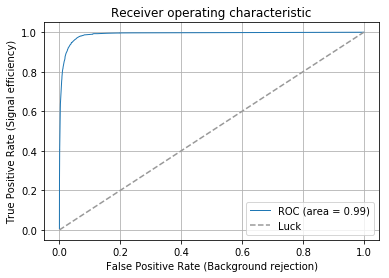

In [ ]:
plotROC(bdt, X_test)

In [ ]:
compare_train_test(bdt, X_train, y_train, X_test, y_test)

In [3]:
df_variable = pd.DataFrame(['user', 'user', 'user', 'taskid', 'taskid', 'taskid', 'site', 'site', 'site', 'cputime', 'cputime',
                            'cputime', 'walltime', 'walltime', 'walltime', 'size', 'size', 'size', 'pandaid', 'pandaid', 'pandaid',
                           'nfiles', 'nfiles', 'nfiles', 'nevents', 'nevents', 'nevents'], columns=['variable'])

In [4]:
df_cut = pd.DataFrame(['15 %', '10 %', '5 %', '15 %', '10 %', '5 %', '15 %', '10 %', '5 %', '15 %', '10 %', '5 %', '15 %', '10 %', '5 %',
                      '15 %', '10 %', '5 %', '15 %', '10 %', '5 %', '15 %', '10 %', '5 %', '15 %', '10 %', '5 %',], columns=['cut'])

In [5]:
df_precision = pd.DataFrame([0.85, 0.84, 0.86, 0.86, 0.86, 0.89, 0.85, 0.85, 0.83, 0.87, 0.83, 0.84, 0.86, 0.86, 0.85, 0.93, 0.91,
                            0.88, 0.87, 0.85, 0.85, 0.88, 0.85, 0.88, 0.91, 0.88, 0.88], columns=['precision'])

In [6]:
df_recall = pd.DataFrame([0.77, 0.75, 0.75, 0.75, 0.72, 0.70, 0.77, 0.76, 0.80, 0.79, 0.79, 0.76, 0.82, 0.79, 0.76, 0.89, 0.89,
                         0.84, 0.83, 0.82, 0.81, 0.83, 0.81, 0.77, 0.87, 0.85, 0.84], columns=['recall'])

In [7]:
df_F1score = pd.DataFrame([0.81, 0.79, 0.80, 0.80, 0.79, 0.78, 0.81, 0.81, 0.81, 0.83, 0.81, 0.80, 0.84, 0.82, 0.80, 0.91, 0.90,
                          0.86, 0.85, 0.84, 0.83, 0.85, 0.83, 0.82, 0.89, 0.87, 0.86], columns=['F1score'])

In [8]:
df_accuracy = pd.DataFrame([0.943, 0.961, 0.981, 0.942, 0.960, 0.980, 0.944, 0.962, 0.981, 0.949, 0.961, 0.980, 0.952, 0.965,
                           0.981, 0.974, 0.980, 0.986, 0.956, 0.968, 0.983, 0.956, 0.966, 0.983, 0.966, 0.973, 0.986],
                          columns=['accuracy'])

In [9]:
df_TPR = pd.DataFrame([77.8, 74.7, 74.8, 75.4, 72.4, 69.7, 76.6, 76.3, 79.7, 78.9, 78.9, 75.9, 82.2, 78.6, 76.1, 88.9, 88.8, 
                      84.2, 82.7, 82.3, 81.1, 82.7, 81.2, 77.3, 87.3, 85.1, 84.4], columns=['TPR'])

In [10]:
df_TNR = pd.DataFrame([97.3, 98.4, 99.3, 97.7, 98.6, 99.5, 97.6, 98.5, 99.1, 97.8, 98.1, 99.2, 97.5, 98.6, 99.3, 98.9, 99.1, 
                      99.4, 97.9, 98.4, 99.2, 97.9, 98.4, 99.4, 98.3, 98.7, 99.4], columns=['TNR'])

In [11]:
df_FPR = pd.DataFrame([2.7, 1.6, 0.7, 2.3, 1.4, 0.5, 2.4, 1.5, 0.9, 2.2, 1.9, 0.8, 2.5, 1.4, 0.7, 1.1, 0.9, 0.6, 2.1, 1.6, 0.8, 
                      2.1, 1.6, 0.6, 1.7, 1.3, 0.6], columns = ['FPR'])

In [12]:
df_FNR = pd.DataFrame([22.2, 25.3, 25.2, 24.6, 27.6, 30.3, 23.4, 23.7, 20.3, 21.1, 21.1, 24.1, 17.8, 21.4, 23.9, 11.1, 11.2, 
                      15.8, 17.3, 17.7, 18.9, 17.3, 18.8, 22.7, 12.7, 14.9, 15.6], columns = ['FNR'])

In [13]:
df_bdt = pd.concat([df_variable, df_cut, df_precision, df_recall, df_F1score, df_accuracy, df_TPR, df_TNR, df_FPR, df_FNR], axis=1)

In [14]:
df_bdt

,variable,cut,precision,recall,F1score,accuracy,TPR,TNR,FPR,FNR
0,user,15 %,0.85,0.77,0.81,0.943,77.8,97.3,2.7,22.2
1,user,10 %,0.84,0.75,0.79,0.961,74.7,98.4,1.6,25.3
2,user,5 %,0.86,0.75,0.80,0.981,74.8,99.3,0.7,25.2
3,taskid,15 %,0.86,0.75,0.80,0.942,75.4,97.7,2.3,24.6
4,taskid,10 %,0.86,0.72,0.79,0.960,72.4,98.6,1.4,27.6
5,taskid,5 %,0.89,0.70,0.78,0.980,69.7,99.5,0.5,30.3
6,site,15 %,0.85,0.77,0.81,0.944,76.6,97.6,2.4,23.4
7,site,10 %,0.85,0.76,0.81,0.962,76.3,98.5,1.5,23.7
8,site,5 %,0.83,0.80,0.81,0.981,79.7,99.1,0.9,20.3
9,cputime,15 %,0.87,0.79,0.83,0.949,78.9,97.8,2.2,21.1


In [15]:
bdt_results = HDFStore('bdt_results.h5')

In [16]:
bdt_results['df_bdt'] = df_bdt

In [17]:
bdt_results

<class 'pandas.io.pytables.HDFStore'>
File path: bdt_results.h5
/df_bdt               frame        (shape->[27,10])
/df_bdt_10            frame        (shape->[9,10]) 
/df_bdt_15            frame        (shape->[9,10]) 
/df_bdt_5             frame        (shape->[9,10]) 

In [18]:
df_bdt_15 = df_bdt[df_bdt.cut == '15 %'].reset_index(drop = True)
df_bdt_10 = df_bdt[df_bdt.cut == '10 %'].reset_index(drop = True)
df_bdt_5 = df_bdt[df_bdt.cut == '5 %'].reset_index(drop = True)

In [51]:
bdt_results['df_bdt_15'] = df_bdt_15

In [52]:
bdt_results['df_bdt_10'] = df_bdt_10

In [53]:
bdt_results['df_bdt_5'] = df_bdt_5

(-0.5, 8.5)

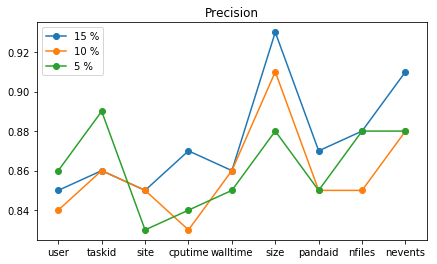

In [24]:
ax = df_bdt_15.precision.plot(marker = 'o', label = '15 %', figsize = (7, 4))
df_bdt_10.precision.plot(ax=ax, marker = 'o', label = '10 %')
df_bdt_5.precision.plot(ax=ax, marker = 'o', label = '5 %')
plt.title('Precision')
plt.legend()
plt.xticks(df_bdt_15.index, df_bdt_15.variable)
plt.xlim([-0.5, 8.5])

In [ ]:
# Proviamo a dare una definizione piu' complessa di popolarita'
# Combiniamo due cut user > 17 con size > 710000000000



